In [1]:
import subprocess
import sys

# INSTALL REQUIRED PACKAGES
packages = ['yfinance', 'ta', 'backtrader']
for package in packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import ta
import backtrader as bt
import matplotlib.dates as mdates
import re

# SETUP MATPLOTLIB FOR CHINESE SUPPORT
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


ticker = 'MSFT'
start_date = '2014-01-01'
end_date = '2024-01-01'
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [2]:

print(" DATA CLEANING AND PREPROCESSING")

# Flatten and rename columns
data_flat = data.copy()
data_flat.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data_flat.columns]
data_flat = data_flat.reset_index()
data_flat = data_flat.rename(columns={
    'Open_MSFT': 'open',
    'High_MSFT': 'high',
    'Low_MSFT': 'low',
    'Close_MSFT': 'close',
    'Volume_MSFT': 'volume'
})


 DATA CLEANING AND PREPROCESSING


In [3]:

 # ==================== Unified Trade Analysis ====================
def analyze_trades(results_dict):
    """
    Analyze trade statistics.
    """
    strategy_name = results_dict['strategy_name']
    trades = results_dict['trades']
    final_value = results_dict['final_value']
    total_return = results_dict['total_return']
    
    print(f"\n{'='*60}")
    print(f"{strategy_name} - Trade Statistics")
    print(f"{'='*60}")
    
    if trades:
        # Support multiple buy/sell types (check 'buy'/'sell' keywords)
        buy_trades = [t for t in trades if 'buy' in t[0]]
        sell_trades = [t for t in trades if 'sell' in t[0]]
        
        print(f"Total trades: {len(trades)}")
        print(f"Buy trades: {len(buy_trades)}")
        print(f"Sell trades: {len(sell_trades)}")
        
        if buy_trades and sell_trades:
            hold_periods = []
            action_set = {t[0] for t in trades}
            if 'buy_signal' in action_set or 'sell_extra' in action_set:
                filtered_trades = [t for t in trades if t[0] in ('buy_signal', 'sell_extra')]
            else:
                filtered_trades = trades
            
            open_buys = []
            for trade in filtered_trades:
                action = trade[0]
                trade_date = pd.to_datetime(trade[1])
                if 'buy' in action:
                    open_buys.append(trade_date)
                elif 'sell' in action:
                    if open_buys:
                        buy_date = open_buys.pop(0)
                        if trade_date >= buy_date:
                            hold_periods.append((trade_date - buy_date).days)
            
            if hold_periods:
                avg_hold_period = sum(hold_periods) / len(hold_periods)
                print(f"Average holding period: {avg_hold_period:.1f} days")
                print(f"Max holding period: {max(hold_periods)} days")
                print(f"Min holding period: {min(hold_periods)} days")
        
        print(f"\nStrategy Performance:")
        print(f"- Initial capital: ${results_dict['initial_cash']:,.0f}")
        print(f"- Final value: ${final_value:,.2f}")
        print(f"- Total return: {total_return:.2f}%")
        
        if total_return > 0:
            print("🎯 Strategy performance: Profit")
        else:
            print("⚠️  Strategy performance: Loss")
    else:
        print("❌ No trades")
    
    print(f"{'='*60}")

# ==================== Helper: Mark Trades on Plot ====================
def mark_trades_on_plot(ax, trades, data_flat):
    """
    Mark trade points on the chart.
    """
    for trade in trades:
        trade_date = pd.to_datetime(trade[1])
        price_row = data_flat[data_flat['Date'] == trade_date]
        if not price_row.empty:
            price = price_row['close'].values[0]
            # Support multiple trade types
            is_buy = 'buy' in trade[0]
            marker = '^' if is_buy else 'v'
            color = 'green' if is_buy else 'red'
            ax.scatter([trade_date], [price], marker=marker, color=color, s=100, zorder=5, 
                      edgecolors='dark'+color, linewidth=1.5)




In [4]:
# ==================== Backtrader Helpers ====================
class ParameterizedMAStrategy(bt.Strategy):
    """Parameterized moving-average crossover strategy with optional trend filter."""
    params = (
        ('sma_short', 10),
        ('sma_long', 30),
        ('sma_trend', 200),
        ('use_trend_filter', False),
        ('capital', 100000),
    )

    def __init__(self):
        self.sma_short = bt.indicators.SMA(self.data.close, period=self.params.sma_short)
        self.sma_long = bt.indicators.SMA(self.data.close, period=self.params.sma_long)
        self.sma_trend = bt.indicators.SMA(self.data.close, period=self.params.sma_trend)
        self.crossover = bt.indicators.CrossOver(self.sma_short, self.sma_long)
        self.trades_log = []

    def next(self):
        if not self.position:
            trend_ok = True
            if self.params.use_trend_filter:
                trend_ok = self.data.close[0] > self.sma_trend[0]
            if self.crossover[0] > 0 and trend_ok:
                size = int(self.broker.getcash() / self.data.close[0])
                if size > 0:
                    self.buy(size=size)
                    self.trades_log.append(('buy', self.data.datetime.date(), size, 'sma_cross'))
        else:
            if self.crossover[0] < 0:
                size = self.position.size
                self.sell(size=size)
                self.trades_log.append(('sell', self.data.datetime.date(), size, 'sma_cross_down'))


def run_backtest(params, strategy_name, strategy_cls):
    """Run a Backtrader backtest and return results in a unified format."""
    cerebro = bt.Cerebro()
    data_feed = bt.feeds.PandasData(
        dataname=data_flat,
        datetime='Date',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
    )
    cerebro.adddata(data_feed)
    initial_cash = params.get('capital', 100000)
    cerebro.broker.setcash(initial_cash)
    cerebro.addstrategy(strategy_cls, **params)
    results = cerebro.run()
    strat = results[0]
    final_value = cerebro.broker.getvalue()
    total_return = (final_value - initial_cash) / initial_cash * 100
    trades = getattr(strat, 'trades_log', [])
    return cerebro, strat, {
        'strategy_name': strategy_name,
        'initial_cash': initial_cash,
        'final_value': final_value,
        'total_return': total_return,
        'trades': trades
    }



📊 Strategy 1: 10/30 SMA Crossover



Strategy 1: 10/30 SMA - Trade Statistics
Total trades: 61
Buy trades: 43
Sell trades: 18
Average holding period: 1112.9 days
Max holding period: 1933 days
Min holding period: 41 days

Strategy Performance:
- Initial capital: $100,000
- Final value: $125,693.68
- Total return: 25.69%
🎯 Strategy performance: Profit

Generating Strategy 1 visualization...
✅ Chart saved: msft_strategy1.png


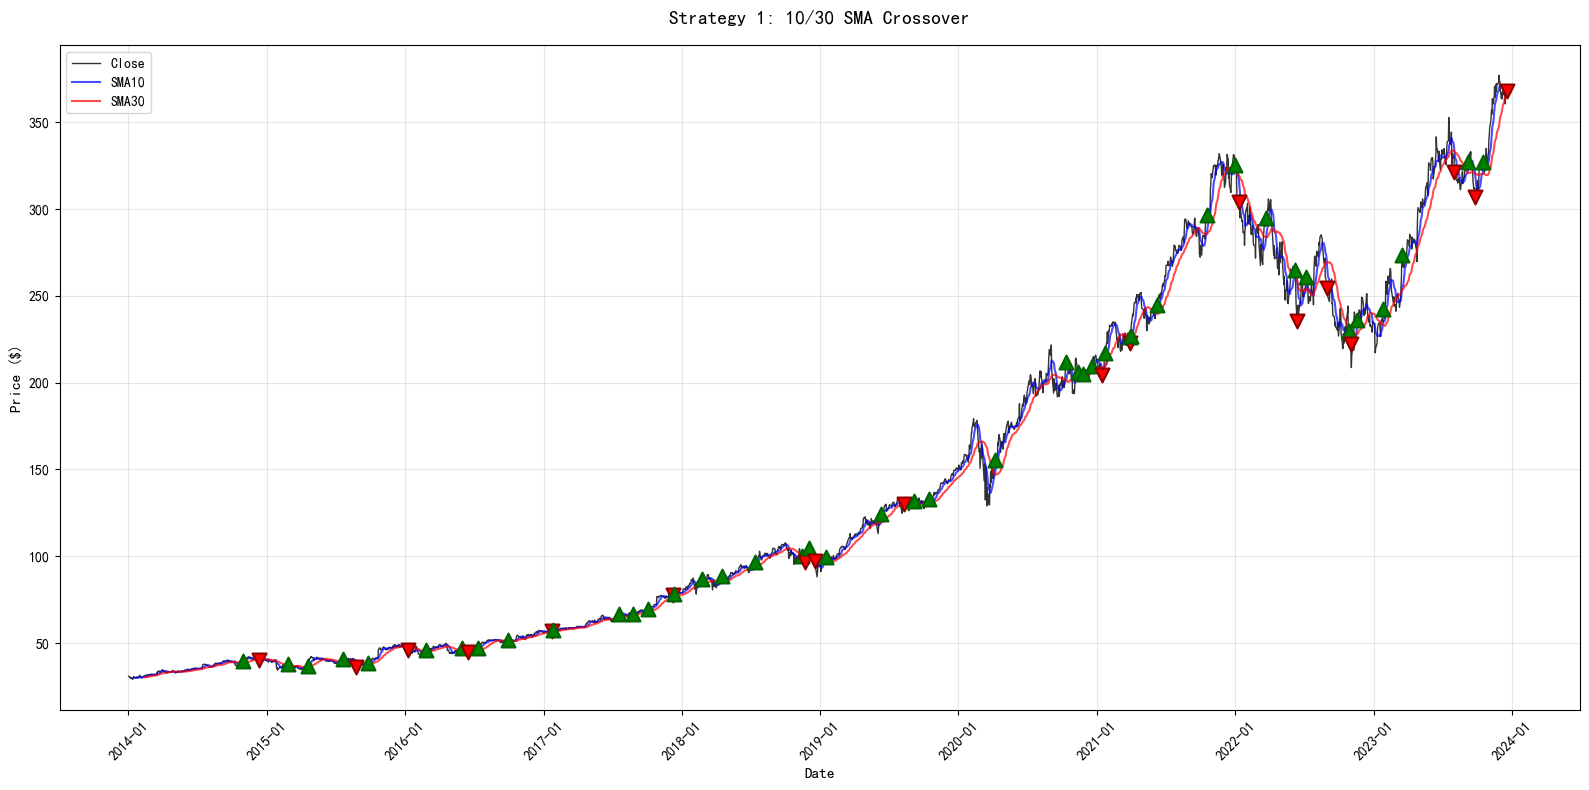

In [5]:
# ==================== Strategy 1: 10/30 SMA Crossover ====================
print("\n" + "=" * 80)
print("📊 Strategy 1: 10/30 SMA Crossover")
print("=" * 80)

strategy1_params = {
    'sma_short': 10,
    'sma_long': 30,
    'capital': 100000
}

cerebro1, strategy1, results1 = run_backtest(strategy1_params, 'Strategy 1: 10/30 SMA', ParameterizedMAStrategy)
analyze_trades(results1)

# Visualize Strategy 1
print("\nGenerating Strategy 1 visualization...")
fig, ax = plt.subplots(figsize=(16, 8))

sma10 = data_flat['close'].rolling(10).mean()
sma30 = data_flat['close'].rolling(30).mean()

ax.plot(data_flat['Date'], data_flat['close'], label='Close', color='black', linewidth=1, alpha=0.8)
ax.plot(data_flat['Date'], sma10, label='SMA10', color='blue', linewidth=1.5, alpha=0.7)
ax.plot(data_flat['Date'], sma30, label='SMA30', color='red', linewidth=1.5, alpha=0.7)
mark_trades_on_plot(ax, results1['trades'], data_flat)

ax.set_title('Strategy 1: 10/30 SMA Crossover', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Price ($)', fontsize=11)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('msft_strategy1.png', dpi=300, bbox_inches='tight')
print("✅ Chart saved: msft_strategy1.png")
plt.show()


📊 Strategy 2: 20/50 SMA + 200 Trend Filter

Strategy 2: 20/50 SMA + 200 Trend Filter - Trade Statistics
Total trades: 32
Buy trades: 21
Sell trades: 11
Average holding period: 691.9 days
Max holding period: 1516 days
Min holding period: 50 days

Strategy Performance:
- Initial capital: $100,000
- Final value: $126,325.96
- Total return: 26.33%
🎯 Strategy performance: Profit

Generating Strategy 2 visualization...
✅ Chart saved: msft_strategy2.png


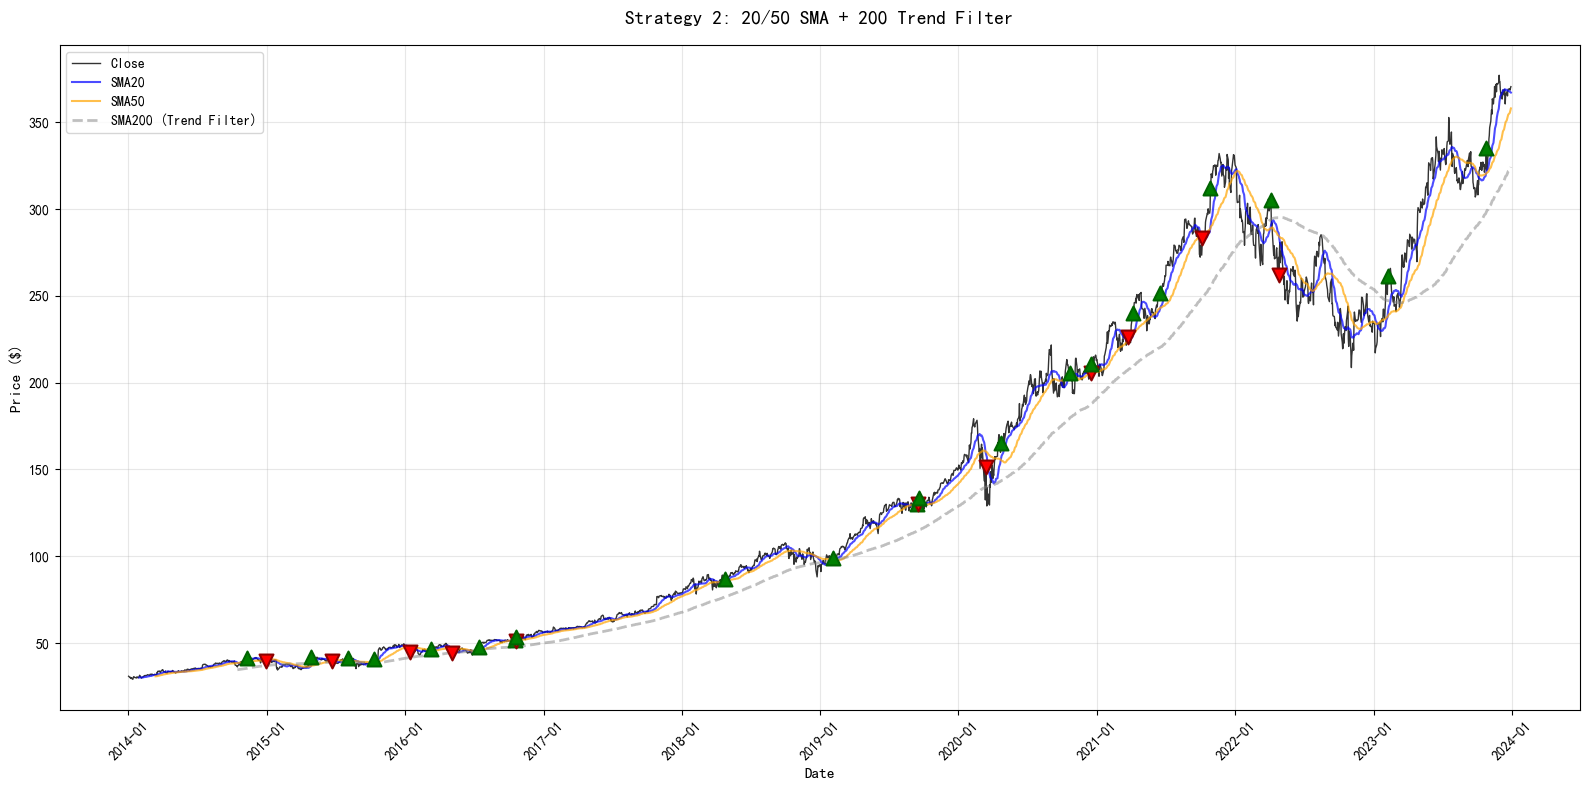

In [6]:
# ==================== Strategy 2: 20/50 SMA + 200 Trend Filter ====================
print("\n" + "=" * 80)
print("📊 Strategy 2: 20/50 SMA + 200 Trend Filter")
print("=" * 80)

strategy2_params = {
    'sma_short': 20,
    'sma_long': 50,
    'sma_trend': 200,
    'use_trend_filter': True,
    'capital': 100000
}

cerebro2, strategy2, results2 = run_backtest(strategy2_params, 'Strategy 2: 20/50 SMA + 200 Trend Filter', ParameterizedMAStrategy)
analyze_trades(results2)

# Visualize Strategy 2
print("\nGenerating Strategy 2 visualization...")
fig, ax = plt.subplots(figsize=(16, 8))

sma20 = data_flat['close'].rolling(20).mean()
sma50 = data_flat['close'].rolling(50).mean()
sma200 = data_flat['close'].rolling(200).mean()

ax.plot(data_flat['Date'], data_flat['close'], label='Close', color='black', linewidth=1, alpha=0.8)
ax.plot(data_flat['Date'], sma20, label='SMA20', color='blue', linewidth=1.5, alpha=0.7)
ax.plot(data_flat['Date'], sma50, label='SMA50', color='orange', linewidth=1.5, alpha=0.7)
ax.plot(data_flat['Date'], sma200, label='SMA200 (Trend Filter)', color='gray', linewidth=2, alpha=0.5, linestyle='--')
mark_trades_on_plot(ax, results2['trades'], data_flat)

ax.set_title('Strategy 2: 20/50 SMA + 200 Trend Filter', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Price ($)', fontsize=11)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('msft_strategy2.png', dpi=300, bbox_inches='tight')
print("✅ Chart saved: msft_strategy2.png")
plt.show()


📊 Strategy 3: MACD + RSI Dual-Indicator Strategy
✅ Strategy 3 defined

Strategy 3: MACD+RSI - Trade Statistics
Total trades: 162
Buy trades: 81
Sell trades: 81
Average holding period: 12.9 days
Max holding period: 50 days
Min holding period: 1 days

Strategy Performance:
- Initial capital: $100,000
- Final value: $166,795.05
- Total return: 66.80%
🎯 Strategy performance: Profit

Generating Strategy 3 visualization...
✅ Chart saved: msft_strategy3_macd_rsi.png


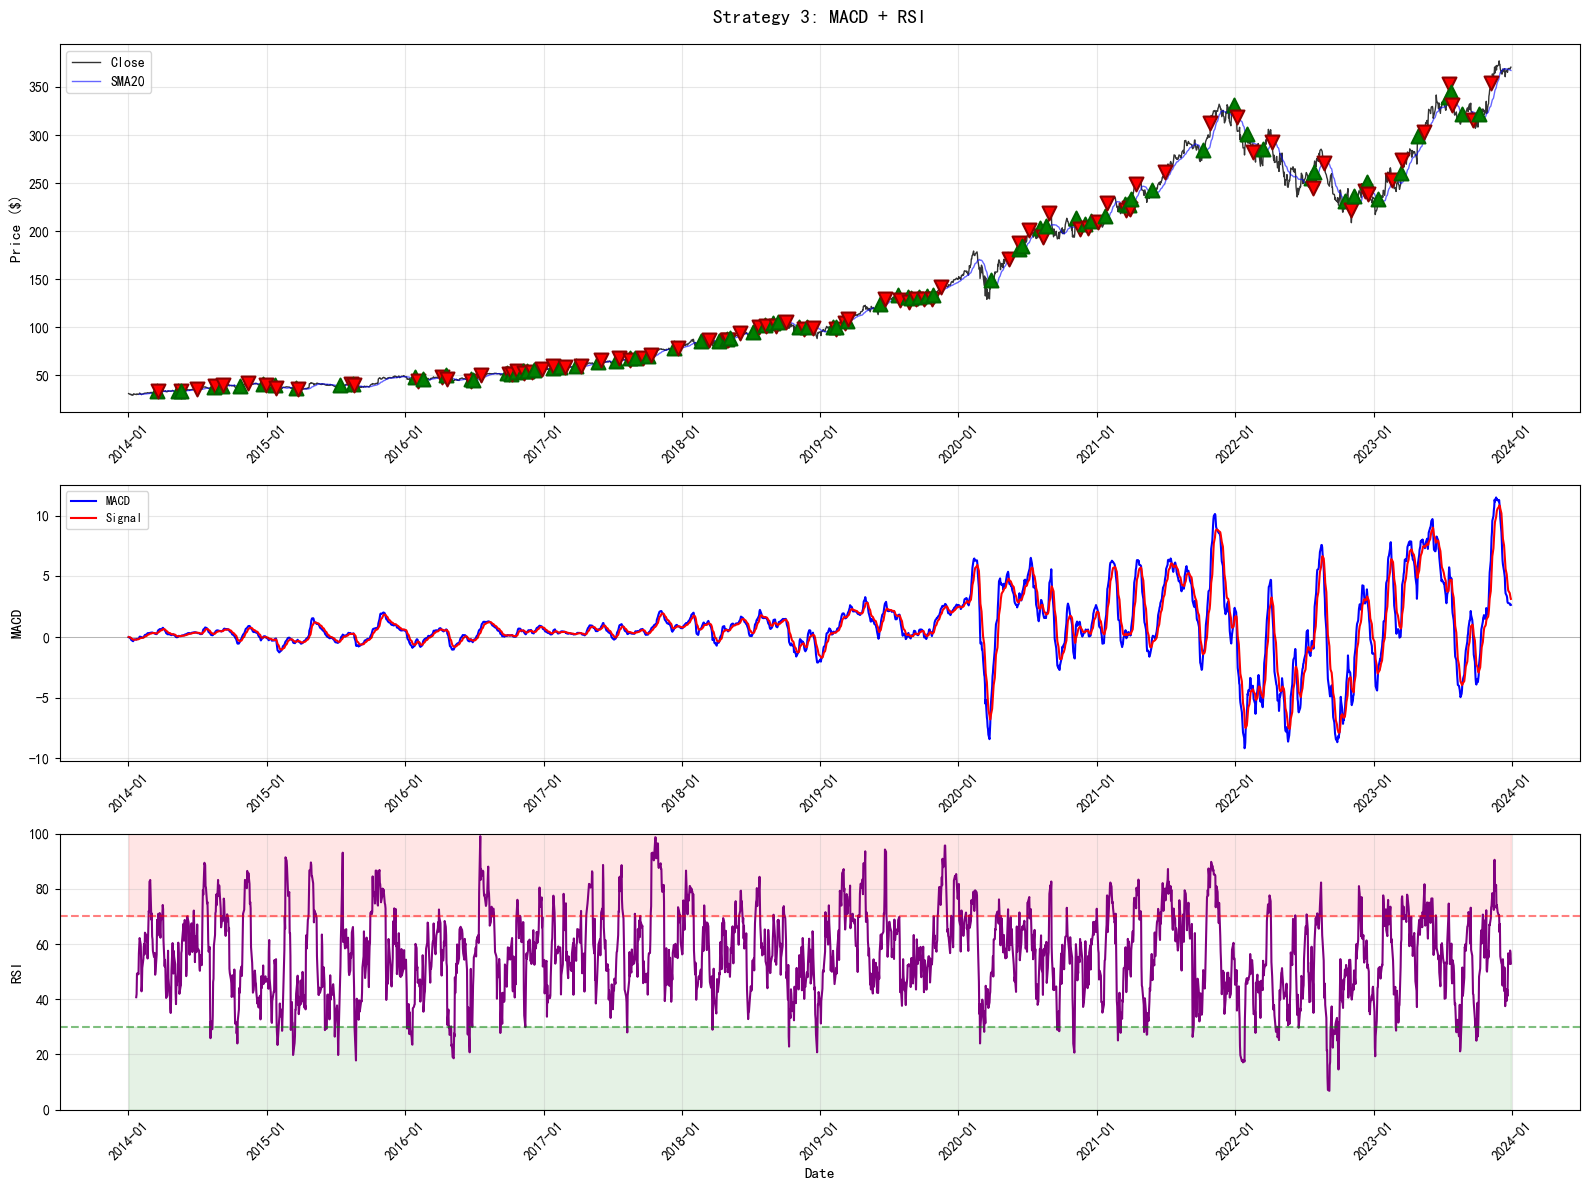

In [7]:
print("\n" + "=" * 80)
print("📊 Strategy 3: MACD + RSI Dual-Indicator Strategy")
print("=" * 80)

# ==================== Strategy 3: MACD + RSI ====================
class Strategy3_MACD_RSI(bt.Strategy):
    """MACD + RSI dual-indicator strategy"""
    params = (('rsi_period', 14), ('capital', 100000),)

    def __init__(self):
        self.macd = bt.indicators.MACD(self.data.close)
        self.macd_line = self.macd.lines.macd
        self.signal_line = self.macd.lines.signal
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.rsi_period)
        self.sma20 = bt.indicators.SMA(self.data.close, period=20)
        self.trades_log = []
        self.in_position = False

    def next(self):
        if not self.in_position:
            macd_up = (self.macd_line[0] > self.signal_line[0] and self.macd_line[-1] <= self.signal_line[-1])
            rsi_ok = 30 < self.rsi[0] < 70
            sma_ok = self.data.close[0] > self.sma20[0]
            if macd_up and rsi_ok and sma_ok:
                size = int(self.broker.getcash() / self.data.close[0])
                self.buy(size=size)
                self.in_position = True
                self.trades_log.append(('buy', self.data.datetime.date(), size, 'macd_cross'))
        else:
            macd_down = (self.macd_line[0] < self.signal_line[0] and self.macd_line[-1] >= self.signal_line[-1])
            rsi_high = self.rsi[0] > 70
            if macd_down or rsi_high:
                self.sell(size=self.position.size)
                self.in_position = False
                self.trades_log.append(('sell', self.data.datetime.date(), self.position.size, 'signal'))

print("✅ Strategy 3 defined")

# Run backtest
strategy3_params = {'rsi_period': 14, 'capital': 100000}
cerebro3, strategy3, results3 = run_backtest(strategy3_params, 'Strategy 3: MACD+RSI', Strategy3_MACD_RSI)
analyze_trades(results3)

# Visualization
print("\nGenerating Strategy 3 visualization...")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [2, 1.5, 1.5]})

sma20_plot = data_flat['close'].rolling(20).mean()
exp1 = data_flat['close'].ewm(span=12, adjust=False).mean()
exp2 = data_flat['close'].ewm(span=26, adjust=False).mean()
macd_line = exp1 - exp2
signal_line = macd_line.ewm(span=9, adjust=False).mean()

delta = data_flat['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rsi_plot = 100 - (100 / (1 + gain / loss))

ax1.plot(data_flat['Date'], data_flat['close'], label='Close', color='black', linewidth=1, alpha=0.8)
ax1.plot(data_flat['Date'], sma20_plot, label='SMA20', color='blue', linewidth=1, alpha=0.6)
mark_trades_on_plot(ax1, results3['trades'], data_flat)
ax1.set_title('Strategy 3: MACD + RSI', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Price ($)', fontsize=11)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

ax2.plot(data_flat['Date'], macd_line, label='MACD', color='blue', linewidth=1.5)
ax2.plot(data_flat['Date'], signal_line, label='Signal', color='red', linewidth=1.5)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax2.set_ylabel('MACD', fontsize=11)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

ax3.plot(data_flat['Date'], rsi_plot, label='RSI(14)', color='purple', linewidth=1.5)
ax3.axhline(y=70, color='red', linestyle='--', alpha=0.5)
ax3.axhline(y=30, color='green', linestyle='--', alpha=0.5)
ax3.fill_between(data_flat['Date'], 70, 100, alpha=0.1, color='red')
ax3.fill_between(data_flat['Date'], 0, 30, alpha=0.1, color='green')
ax3.set_ylabel('RSI', fontsize=11)
ax3.set_xlabel('Date', fontsize=11)
ax3.set_ylim([0, 100])
ax3.grid(True, alpha=0.3)

for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('msft_strategy3_macd_rsi.png', dpi=300, bbox_inches='tight')
print("✅ Chart saved: msft_strategy3_macd_rsi.png")
plt.show()



📊 Strategy 4: MACD + RSI + 50% Base Position (Target Allocation)
✅ Strategy 4 (Target Allocation) defined

Strategy 4: MACD+RSI+50% Base Position - Trade Statistics
Total trades: 261
Buy trades: 82
Sell trades: 179
Average holding period: 29.7 days
Max holding period: 134 days
Min holding period: 1 days

Strategy Performance:
- Initial capital: $100,000
- Final value: $456,692.82
- Total return: 356.69%
🎯 Strategy performance: Profit

Generating Strategy 4 visualization...
✅ Chart saved: msft_strategy4_macd_rsi_50pct_target.png


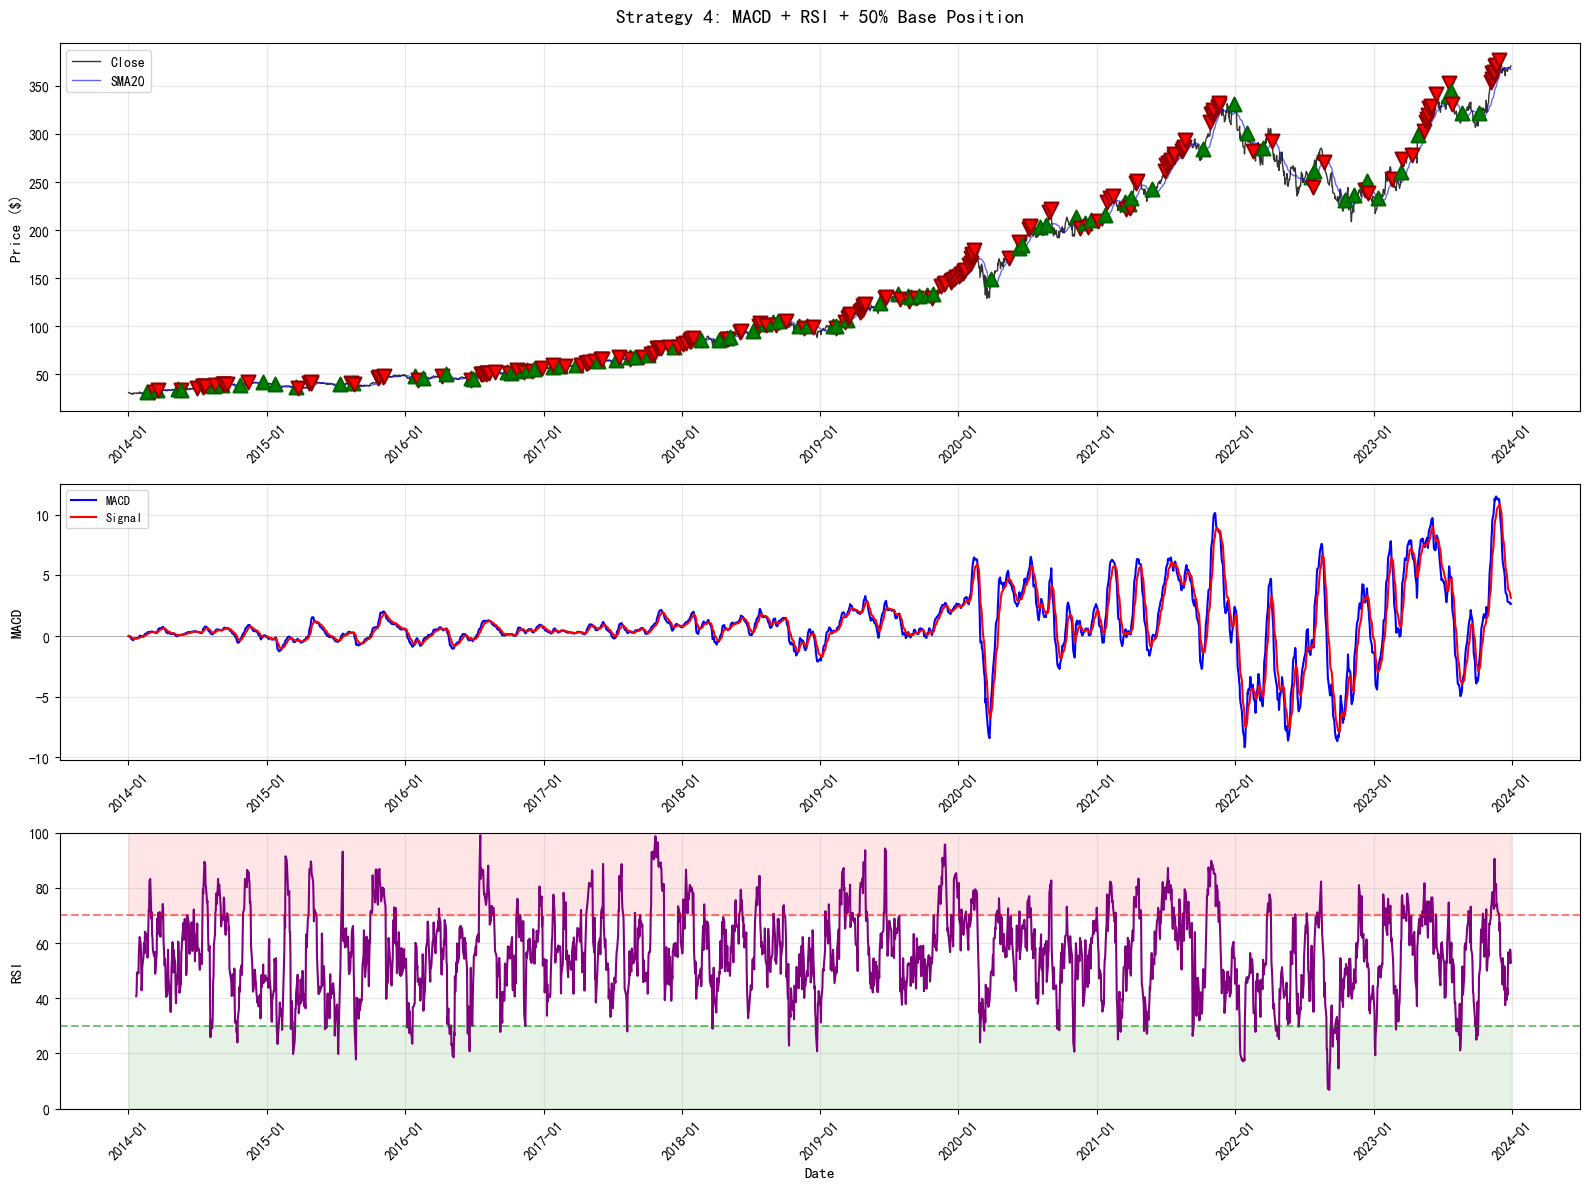

In [8]:
print("\n" + "=" * 80)
print("📊 Strategy 4: MACD + RSI + 50% Base Position (Target Allocation)")
print("=" * 80)

# ==================== Strategy 4: MACD + RSI + 50% Base Position ====================
class Strategy4_MACD_RSI_50pct(bt.Strategy):
    """MACD + RSI dual-indicator strategy with target allocation (50%-100%)"""
    params = (
        ('rsi_period', 14),
        ('capital', 100000),
        ('min_pct', 0.5),   # Base position ratio
        ('max_pct', 1.0),   # Max allocation when signal triggers
    )

    def __init__(self):
        self.macd = bt.indicators.MACD(self.data.close)
        self.macd_line = self.macd.lines.macd
        self.signal_line = self.macd.lines.signal
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.rsi_period)
        self.sma20 = bt.indicators.SMA(self.data.close, period=20)
        self.trades_log = []
        self.base_init = False

    def _current_pct(self):
        value = self.broker.getvalue()
        pos_value = self.position.size * self.data.close[0]
        return pos_value / value if value > 0 else 0

    def next(self):
        # Initialization: build base position
        if not self.base_init:
            self.order_target_percent(target=self.params.min_pct)
            self.trades_log.append(('buy_init', self.data.datetime.date(), self.params.min_pct, 'init_base'))
            self.base_init = True
        
        current_pct = self._current_pct()
        
        # Signal checks
        macd_up = (self.macd_line[0] > self.signal_line[0] and self.macd_line[-1] <= self.signal_line[-1])
        macd_down = (self.macd_line[0] < self.signal_line[0] and self.macd_line[-1] >= self.signal_line[-1])
        rsi_ok = 30 < self.rsi[0] < 70
        rsi_high = self.rsi[0] > 70
        sma_ok = self.data.close[0] > self.sma20[0]
        
        # Increase: from 50% to 100%
        if macd_up and rsi_ok and sma_ok and current_pct < self.params.max_pct - 1e-3:
            self.order_target_percent(target=self.params.max_pct)
            self.trades_log.append(('buy_signal', self.data.datetime.date(), self.params.max_pct, 'macd_cross'))
        
        # Decrease: from 100% back to 50% (keep base position)
        if (macd_down or rsi_high) and current_pct > self.params.min_pct + 1e-3:
            self.order_target_percent(target=self.params.min_pct)
            self.trades_log.append(('sell_extra', self.data.datetime.date(), self.params.min_pct, 'reduce_to_base'))

print("✅ Strategy 4 (Target Allocation) defined")

# Run backtest
strategy4_params = {'rsi_period': 14, 'capital': 100000, 'min_pct': 0.5, 'max_pct': 1.0}
cerebro4, strategy4, results4 = run_backtest(strategy4_params, 'Strategy 4: MACD+RSI+50% Base Position', Strategy4_MACD_RSI_50pct)
analyze_trades(results4)

# Visualization
print("\nGenerating Strategy 4 visualization...")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [2, 1.5, 1.5]})

sma20_plot = data_flat['close'].rolling(20).mean()
exp1 = data_flat['close'].ewm(span=12, adjust=False).mean()
exp2 = data_flat['close'].ewm(span=26, adjust=False).mean()
macd_line = exp1 - exp2
signal_line = macd_line.ewm(span=9, adjust=False).mean()

delta = data_flat['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rsi_plot = 100 - (100 / (1 + gain / loss))

ax1.plot(data_flat['Date'], data_flat['close'], label='Close', color='black', linewidth=1, alpha=0.8)
ax1.plot(data_flat['Date'], sma20_plot, label='SMA20', color='blue', linewidth=1, alpha=0.6)
mark_trades_on_plot(ax1, results4['trades'], data_flat)
ax1.set_title('Strategy 4: MACD + RSI + 50% Base Position', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Price ($)', fontsize=11)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

ax2.plot(data_flat['Date'], macd_line, label='MACD', color='blue', linewidth=1.5)
ax2.plot(data_flat['Date'], signal_line, label='Signal', color='red', linewidth=1.5)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax2.set_ylabel('MACD', fontsize=11)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

ax3.plot(data_flat['Date'], rsi_plot, label='RSI(14)', color='purple', linewidth=1.5)
ax3.axhline(y=70, color='red', linestyle='--', alpha=0.5)
ax3.axhline(y=30, color='green', linestyle='--', alpha=0.5)
ax3.fill_between(data_flat['Date'], 70, 100, alpha=0.1, color='red')
ax3.fill_between(data_flat['Date'], 0, 30, alpha=0.1, color='green')
ax3.set_ylabel('RSI', fontsize=11)
ax3.set_xlabel('Date', fontsize=11)
ax3.set_ylim([0, 100])
ax3.grid(True, alpha=0.3)

for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('msft_strategy4_macd_rsi_50pct_target.png', dpi=300, bbox_inches='tight')
print("✅ Chart saved: msft_strategy4_macd_rsi_50pct_target.png")
plt.show()


In [9]:
import json
from datetime import datetime

# ==================== Calculate Advanced Risk Metrics ====================
def calculate_advanced_metrics(results_dict, data_flat):
    """Calculate max drawdown, Sharpe ratio, and other advanced metrics"""
    trades = results_dict['trades']
    initial_cash = results_dict['initial_cash']
    final_value = results_dict['final_value']
    
    # Daily returns from equity curve (reconstruct from trades)
    def _build_equity_curve(trades, data_flat, initial_cash):
        data = data_flat[['Date', 'close']].copy()
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.sort_values('Date')
        trades_sorted = sorted(trades, key=lambda t: pd.to_datetime(t[1]))
        trade_idx = 0
        cash = float(initial_cash)
        position = 0
        equity = []
        for date, price in zip(data['Date'], data['close']):
            # process all trades on this date
            while trade_idx < len(trades_sorted) and pd.to_datetime(trades_sorted[trade_idx][1]) == date:
                action = trades_sorted[trade_idx][0]
                size = trades_sorted[trade_idx][2] if len(trades_sorted[trade_idx]) > 2 else None
                if size is None:
                    trade_idx += 1
                    continue
                # skip non-numeric sizes
                if isinstance(size, str):
                    trade_idx += 1
                    continue
                size = float(size)
                # strategy 4 uses target percent sizes (0-1)
                if 0 < size <= 1:
                    total_value = cash + position * price
                    target_value = total_value * size
                    target_shares = int(target_value / price) if price > 0 else 0
                    delta = target_shares - position
                    if delta > 0:
                        cost = delta * price
                        if cost <= cash:
                            cash -= cost
                            position += delta
                        else:
                            affordable = int(cash / price)
                            cash -= affordable * price
                            position += affordable
                    elif delta < 0:
                        sell_shares = min(position, -delta)
                        cash += sell_shares * price
                        position -= sell_shares
                else:
                    shares = int(size)
                    if 'buy' in action:
                        cost = shares * price
                        if cost <= cash:
                            cash -= cost
                            position += shares
                        else:
                            affordable = int(cash / price)
                            cash -= affordable * price
                            position += affordable
                    elif 'sell' in action:
                        sell_shares = min(position, shares)
                        cash += sell_shares * price
                        position -= sell_shares
                trade_idx += 1
            equity.append(cash + position * price)
        return pd.Series(equity, index=data['Date'])
    
    equity_curve = _build_equity_curve(trades, data_flat, initial_cash)
    daily_returns = equity_curve.pct_change().dropna() if len(equity_curve) > 1 else pd.Series(dtype=float)
    
    # Daily returns (simplified based on trades)
    buy_trades = [t for t in trades if 'buy' in t[0]]
    sell_trades = [t for t in trades if 'sell' in t[0]]
    
    # Return statistics
    returns_list = []
    wins = 0
    losses = 0
    total_profit = 0
    total_loss = 0
    
    for i in range(min(len(buy_trades), len(sell_trades))):
        buy_date = buy_trades[i][1]
        sell_date = sell_trades[i][1]
        
        buy_price = data_flat[data_flat['Date'] == pd.to_datetime(buy_date)]['close'].values
        sell_price = data_flat[data_flat['Date'] == pd.to_datetime(sell_date)]['close'].values
        
        if len(buy_price) > 0 and len(sell_price) > 0:
            ret = (sell_price[0] - buy_price[0]) / buy_price[0]
            returns_list.append(ret)
            
            if ret > 0:
                wins += 1
                total_profit += ret
            else:
                losses += 1
                total_loss += abs(ret)
    
    # Basic metrics
    total_trades = len(returns_list)
    win_rate = (wins / total_trades * 100) if total_trades > 0 else 0
    profit_factor = (total_profit / total_loss) if total_loss > 0 else float('inf')
    
    # Max drawdown (from equity curve)
    if len(equity_curve) > 0:
        roll_max = equity_curve.cummax()
        drawdown = equity_curve / roll_max - 1
        max_drawdown = -drawdown.min() * 100 if drawdown.min() < 0 else 0
    else:
        max_drawdown = 0
    
    # Sharpe ratio (from daily returns)
    if len(daily_returns) > 0:
        avg_return = daily_returns.mean()
        std_return = daily_returns.std()
        sharpe_ratio = (avg_return / std_return) * np.sqrt(252) if std_return > 0 else 0
    else:
        sharpe_ratio = 0
        avg_return = 0
    
    # Annualized return
    total_return = results_dict['total_return']
    years = 10  # 2014-2024
    annualized_return = ((1 + total_return/100) ** (1/years) - 1) * 100
    
    # Annualized volatility
    annualized_volatility = std_return * np.sqrt(252) * 100 if len(daily_returns) > 0 else 0
    
    return {
        'max_drawdown': round(max_drawdown, 2),
        'sharpe_ratio': round(sharpe_ratio, 2),
        'annualized_return': round(annualized_return, 2),
        'annualized_volatility': round(annualized_volatility, 2),
        'win_rate': round(win_rate, 2),
        'profit_factor': round(profit_factor, 2),
        'total_trades': total_trades,
        'wins': wins,
        'losses': losses,
        'avg_return_per_trade': round(avg_return * 100, 2)
    }


 # ==================== Generate Full Report for All Strategies ====================
all_results = {
    'strategy1': results1,
    'strategy2': results2,
    'strategy3': results3,
    'strategy4': results4
}

performance_report = {
    'report_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'ticker': 'MSFT',
    'period': '2014-01-01 to 2024-01-01',
    'strategies': {}
}

all_trades_data = []

for key, results in all_results.items():
    print(f"\nCalculating advanced metrics for {results['strategy_name']}...")
    
    advanced_metrics = calculate_advanced_metrics(results, data_flat)
    
    strategy_report = {
        'name': results['strategy_name'],
        'basic_metrics': {
            'initial_cash': results['initial_cash'],
            'final_value': round(results['final_value'], 2),
            'total_return_pct': round(results['total_return'], 2),
            'total_trades': len(results['trades'])
        },
        'risk_metrics': advanced_metrics
    }
    
    performance_report['strategies'][key] = strategy_report
    
    # Collect trade details
    for trade in results['trades']:
        trade_date = pd.to_datetime(trade[1])
        price_data = data_flat[data_flat['Date'] == trade_date]
        
        trade_record = {
            'strategy': results['strategy_name'],
            'action': trade[0],
            'date': str(trade[1]),
            'price': round(price_data['close'].values[0], 2) if len(price_data) > 0 else 0,
            'size': trade[2] if len(trade) > 2 else 'N/A',
            'reason': trade[3] if len(trade) > 3 else 'N/A'
        }
        all_trades_data.append(trade_record)

# ==================== Save JSON Report ====================
json_filename = 'strategy_performance_report.json'
with open(json_filename, 'w', encoding='utf-8') as f:
    json.dump(performance_report, f, indent=2, ensure_ascii=False)
print(f"\n✅ JSON report saved: {json_filename}")

# ==================== Save Trade Details CSV ====================
trades_df = pd.DataFrame(all_trades_data)
csv_filename = 'all_trades_details.csv'
trades_df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
print(f"✅ Trade details CSV saved: {csv_filename}")





Calculating advanced metrics for Strategy 1: 10/30 SMA...

Calculating advanced metrics for Strategy 2: 20/50 SMA + 200 Trend Filter...

Calculating advanced metrics for Strategy 3: MACD+RSI...

Calculating advanced metrics for Strategy 4: MACD+RSI+50% Base Position...

✅ JSON report saved: strategy_performance_report.json
✅ Trade details CSV saved: all_trades_details.csv


In [ ]:
import json
from datetime import datetime
import requests

# Read the two report files
with open('strategy_performance_report.json', 'r', encoding='utf-8') as f:
    json_report = json.load(f)

trades_df = pd.read_csv('all_trades_details.csv', encoding='utf-8-sig')

# Build LLM prompt
prompt = f"""
You are a senior quantitative investment analyst. Based on the following backtest data for four MSFT trading strategies, generate a 1–2 page professional investment analysis report in English.

[Overview]
Backtest period: 2014-01-01 to 2024-01-01 (10 years)
Ticker: MSFT (Microsoft)
Initial capital: $100,000

[Summary of Four Strategies]
{json.dumps(json_report['strategies'], indent=2, ensure_ascii=False)}

[Report Requirements]
Write a professional report with clear logic and coherent flow. Use explicit section headings and keep the argument progression tight and data-driven.
Required structure:
1) Executive Summary (2–4 concise bullet points)
2) Market & data context (brief)
3) Strategy performance comparison (include a comparison table)
4) Strategy-by-strategy deep insights (use the same order as the summary)
5) Risk analysis and limitations
6) Investment recommendations and rationale
7) Conclusion
For each strategy, explicitly report and interpret these metrics: Sharpe ratio, CAGR (use annualized_return), maximum drawdown, and win rate.
Include a concise comparison table that lists those metrics side-by-side for all four strategies.
Use professional tone, avoid hype, and keep claims grounded in the provided data only.
"""

# Call DeepSeek API 
DEEPSEEK_API_KEY = "sk-b1dc0f6dc8b04892a4a8534d0396cabb"

url = "https://api.deepseek.com/v1/chat/completions"
headers = {
    "Authorization": f"Bearer {DEEPSEEK_API_KEY}",
    "Content-Type": "application/json"
}
payload = {
    "model": "deepseek-chat",
    "messages": [{"role": "user", "content": prompt}],
    "temperature": 0.7,
    "max_tokens": 2000
}
response = requests.post(url, headers=headers, json=payload, timeout=60)
response.raise_for_status()
ai_report = response.json()["choices"][0]["message"]["content"]

# Save AI report
ai_report_filename = 'AI_Investment_Report.txt'
with open(ai_report_filename, 'w', encoding='utf-8') as f:
    f.write(ai_report)

Vision request failed: 400 {"error":{"message":"Failed to deserialize the JSON body into the target type: messages[0]: unknown variant `image_url`, expected `text` at line 1 column 274142","type":"invalid_request_error","param":null,"code":"invalid_request_error"}}
